**Question 1**

In [77]:
import numpy as np
import pandas as pd

In [78]:
data = pd.read_csv('Iris.csv')
data.head()

Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

In [79]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data['Species']= label_encoder.fit_transform(data['Species'])

data['Species'].unique()

array([0, 1, 2])

**RandomForest Classifier**

In [80]:
import random
import math
from collections import Counter




In [81]:
# Calculate Entropy
def entropy(y: np.ndarray) -> np.float64:
    """
    Calculate the entropy of a given set of labels.

    Parameters:
    y (array-like): Labels array.

    Returns:
    float: Entropy value.
    """
    # Count the occurrences of each class label
    class_counts = Counter(y)

    # Calculate the total number of instances
    total_instances = len(y)

    # Initialize entropy value
    entropy_value = 0.0

    # Calculate entropy using the formula
    for count in class_counts.values():
        proportion = count / total_instances
        entropy_value -= proportion * math.log2(proportion)

    return entropy_value


In [82]:
# Create Node
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


In [83]:





#Decision Tree
class DecissionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None, max_features='auto'):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None
        self.max_features = max_features

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.cols = list(X.columns)
        self.root = self.grow_tree(X, y)

    def grow_tree(self, X, y, depth=0):

        df = X.copy()
        df['target'] = y

        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self.most_common_label(y)
            return Node(value=leaf_value)

        # array of random columns in Dataset

        data = self.feature_sampling(X, self.max_features)

        feats_idxs = list(data.columns)

        best_feat, best_thresh = self.best_criteria(X, y.tolist(), feats_idxs)

        left_df, right_df = df[df[best_feat]<=best_thresh].copy(), df[df[best_feat]>best_thresh].copy()

        left = self.grow_tree(left_df.drop('target', axis=1), left_df['target'].values, depth+1)
        right = self.grow_tree(right_df.drop('target', axis=1), right_df['target'].values, depth+1)

        return Node(best_feat, best_thresh, left, right)

    def best_criteria(self, X, y, feats_idxs):
        best_gain = -1
        split_idx, split_tresh = None, None

        X = X.to_numpy()

        for feats_idx in feats_idxs:

            index = int(self.cols.index(feats_idx))

            df = pd.DataFrame(X[:, index], columns=['X_col'])
            df['y'] = y
            df = df.sort_values(by=['X_col'], ascending=True)

            X_col_2 = df.X_col
            y_2 = df.y

            X_col_2 = X_col_2.to_numpy()
            y_2 = y_2.to_numpy()

            for val in X_col_2:
                gain = self.information_gain(y_2, X_col_2, val)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feats_idx
                    split_tresh = val

        return split_idx, split_tresh

    def information_gain(self, y, X_col, thresh):
        parent_entropy = entropy(y)

        left, right = self.split(X_col, thresh)

        if len(left) == 0 or len(right) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left), len(right)
        e_l, e_r = entropy(y[left]), entropy(y[right])

        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        ig = parent_entropy - child_entropy
        return ig

    def split(self, X_col, split_tresh):

        left_idxs = np.argwhere(X_col <= split_tresh).flatten()
        right_idxs = np.argwhere(X_col > split_tresh).flatten()

        return left_idxs, right_idxs

    def most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        X = X.to_numpy().tolist()
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        index = int(self.cols.index(node.feature))

        if x[index] <= node.threshold:
            return self.traverse_tree(x, node.left)

        return self.traverse_tree(x, node.right)

    def feature_sampling(self, data, val):
        if type(val) == int:
            col = random.sample(data.columns.tolist()[:], val)
            new_df = data[col]
            return new_df
        elif type(val) == float:
            col = random.sample(data.columns.tolist()[:], int(val * data.shape[1]))
            new_df = data[col]
            return new_df
        elif val == 'auto' or val == 'sqrt':
            col = random.sample(data.columns.tolist()[:], int(math.sqrt(data.shape[1])))
            new_df = data[col]
            return new_df
        elif val == 'log2':
            col = random.sample(data.columns.tolist()[:], int(math.log2(data.shape[1])))
            new_df = data[col]
            return new_df
        else:
            return data




In [84]:
class randomforestclassifier:
    def __init__(self, n_estimators=100, criterion='entropy', max_depth=None, min_samples_split=2, bootstrap=True, max_samples=None,
                 max_features='auto', oob_score=False):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.bootstrap = bootstrap
        self.max_samples = max_samples
        self.max_features = max_features
        self.oob_score = oob_score

    def fit(self, X_train, y_train):
        dummy_data = X_train.copy()
        dummy_data['target'] = y_train

        self.tree_list = []

        for i in range(self.n_estimators):

            if self.bootstrap == True:
                df = self.row_sampling(dummy_data, self.max_samples)
            else:
                df = dummy_data.copy()

            tree = DecissionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, max_features=self.max_features)

            tree.fit(df.drop('target', axis=1), df.target)

            self.tree_list.append(tree)


    def predict(self, X_test):
        y_preds = np.empty((X_test.shape[0], len(self.tree_list)))
        # Let each tree make a prediction on the data
        for i, tree in enumerate(self.tree_list):
            # Indices of the features that the tree has trained on
            # idx = tree.feature_indices
            # Make a prediction based on those features
            prediction = tree.predict(X_test)
            y_preds[:, i] = prediction

        y_pred = []
        # For each sample
        for sample_predictions in y_preds:
            # Select the most common class prediction
            y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
        return y_pred

    def score(self, y_true=None, y_pred=None):
        acc = np.sum(y_true == y_pred)/len(y_true)
        return acc

    def row_sampling(self, data, val):
        if type(val) == float:
            return data.sample(int(val * data.shape[0]), replace=True)
        if type(val) == int:
            return data.sample(val, replace=True)
        if val == None:
            return data

**Main Function**

In [85]:
if __name__ == '__main__':
    x = data.drop('Species', axis=1)
    y = data.Species

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    re = randomforestclassifier(n_estimators=10, max_depth=5, min_samples_split=5, max_samples=50, max_features=3)

    re.fit(X_train, y_train)

In [86]:
y_pred = re.predict(X_test)

**ACCURACY**

In [87]:
sc = re.score(y_test, y_pred)
print('Accuracy :', sc)

Accuracy : 1.0


****

**Part 3-**

In [88]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

In [89]:
# Set parameters for synthetic data generation
n_samples = 100  # Number of samples
n_features = 6   # Number of features
n_informative = 3  # Number of informative features that influence the output
noise_level = 20  # Noise level in the data


In [90]:
# Generate synthetic regression data using make_regression
X, y, coef = make_regression(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                             random_state=None, shuffle=False, noise=noise_level, coef=True)

# Shuffle the data
np.random.shuffle(X)
np.random.shuffle(y)

In [91]:

# Create DataFrame for the data
df1 = pd.DataFrame(data=X, columns=['X'+str(i) for i in range(1, n_features+1)])
df2 = pd.DataFrame(data=y, columns=['y'])
df = pd.concat([df1, df2], axis=1)


In [92]:
# Display the first 10 rows of the DataFrame
print(df.head(10))

         X1        X2        X3        X4        X5        X6           y
0  1.546775  0.396016 -1.626110 -2.375380 -0.360179  3.516717   83.673639
1  1.075023  1.022306  0.712459  1.980767  0.793838 -0.596464 -113.100826
2 -1.180825 -1.056011 -1.883375 -1.268334 -0.458466  0.697697   97.883861
3 -0.607755 -1.300952  0.219372  0.322346 -0.167571  1.121513  -67.456109
4  0.939526  2.228417  0.982343 -0.456155 -0.332957  0.849933   -2.296713
5  0.797593  0.955204  0.477926 -0.655430 -1.616478  1.134374  -54.701242
6  1.094831 -1.227367 -1.895584  0.798009 -1.372560 -1.901168  -12.097531
7  1.037803 -1.462522 -1.880320 -0.042117 -0.073430 -0.660589   50.849562
8  0.111962 -0.956068  1.396345  1.342708 -1.496681  1.196979  219.685379
9  1.450422  2.814187 -0.696536 -1.877425  1.616506  0.930290  -60.800506


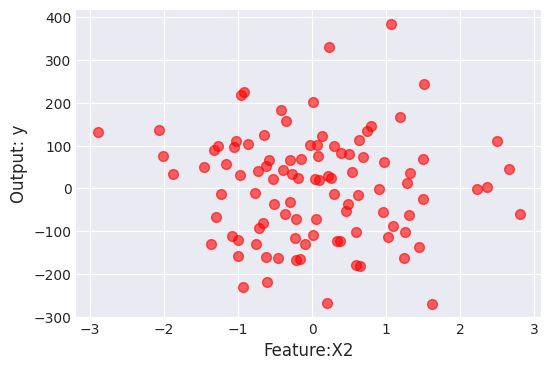

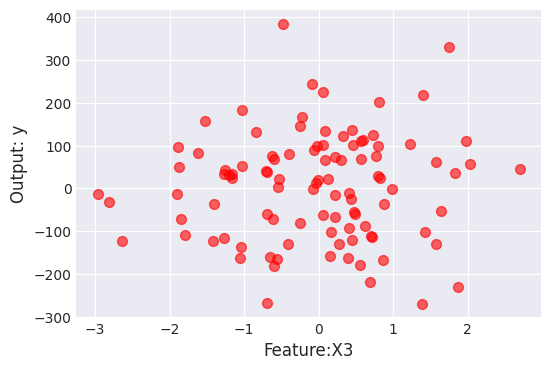

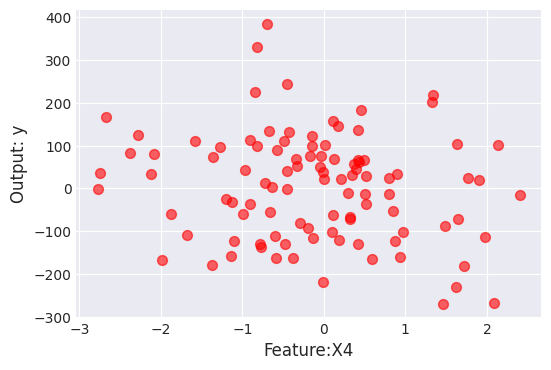

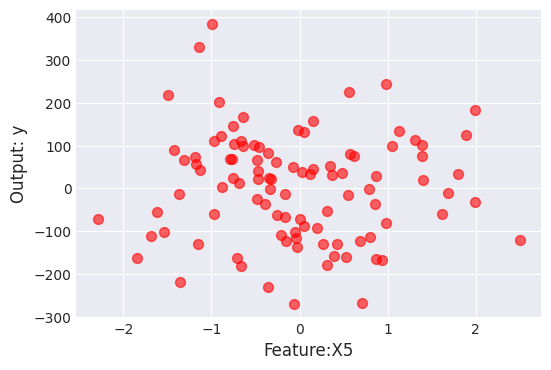

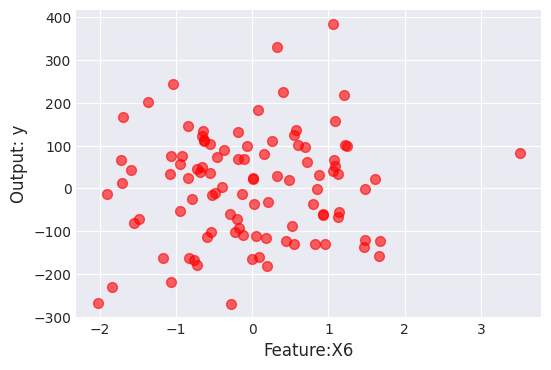

In [93]:
# Visualize data using scatter plots with seaborn-dark style
with plt.style.context(('seaborn-dark')):
    for i, col in enumerate(df.columns[:-1]):
        plt.figure(figsize=(6, 4))
        plt.grid(True)
        plt.xlabel('Feature:'+col, fontsize=12)
        plt.ylabel('Output: y', fontsize=12)
        plt.scatter(df[col], df['y'], c='red', s=50, alpha=0.6)

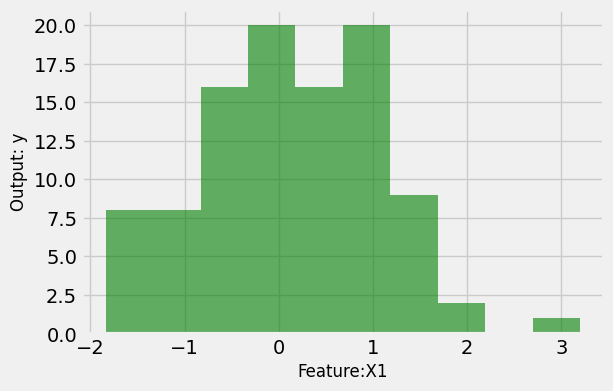

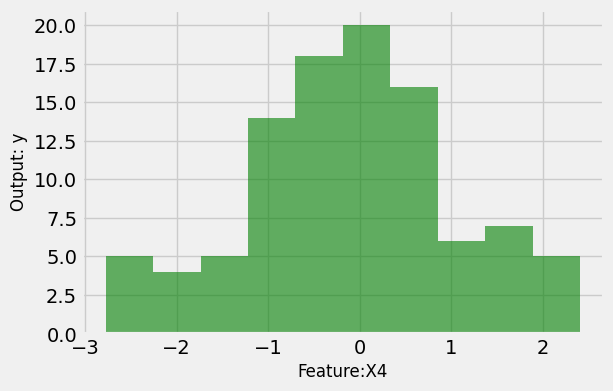

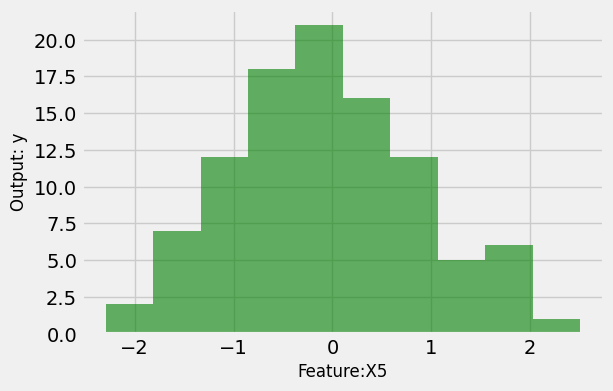

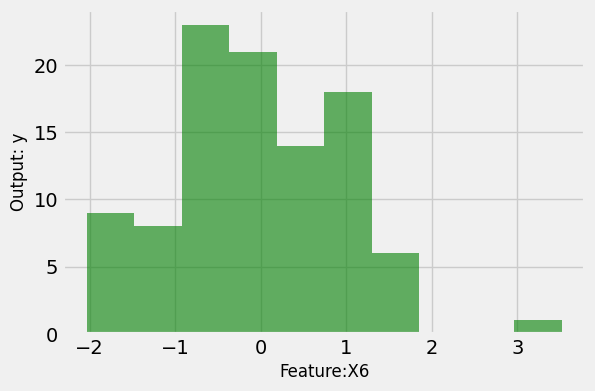

In [94]:
# Visualize data using histograms with fivethirtyeight style
with plt.style.context(('fivethirtyeight')):
    for i, col in enumerate(df.columns[:-1]):
        plt.figure(figsize=(6, 4))
        plt.grid(True)
        plt.xlabel('Feature:'+col, fontsize=12)
        plt.ylabel('Output: y', fontsize=12)
        plt.hist(df[col], alpha=0.6, facecolor='g')

In [95]:
# Train a Random Forest Regressor model
model = RandomForestRegressor(max_depth=None, random_state=None, max_leaf_nodes=2, n_estimators=100)
model.fit(X, y)

# Print the relative importance of the features in the trained model
print("Relative importance of the features: ", model.feature_importances_)


Relative importance of the features:  [0.29 0.04 0.08 0.18 0.22 0.19]


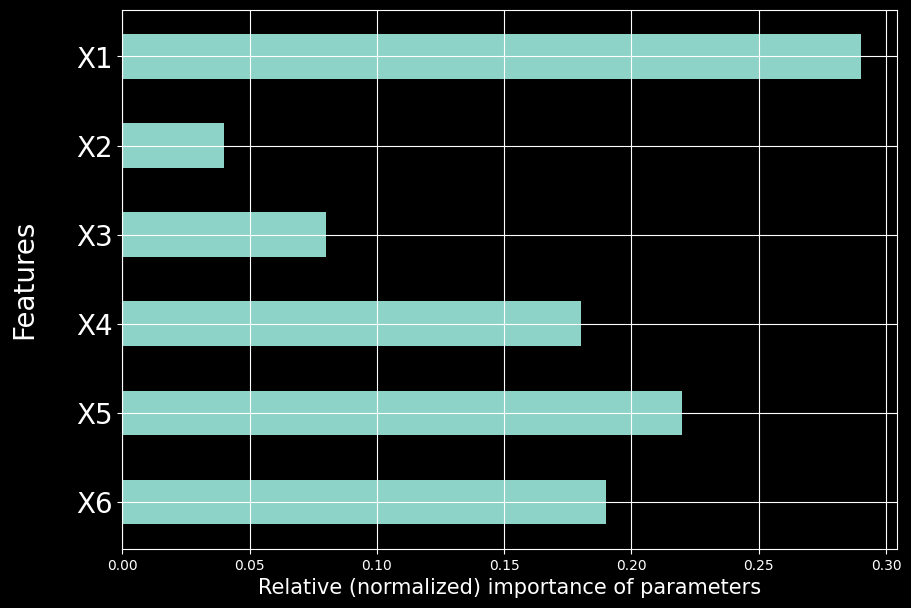

In [96]:

# Visualize feature importances using a horizontal bar chart with dark_background style
with plt.style.context('dark_background'):
    plt.figure(figsize=(10, 7))
    plt.grid(True)
    plt.yticks(range(n_features+1, 1, -1), df.columns[:-1], fontsize=20)
    plt.xlabel("Relative (normalized) importance of parameters", fontsize=15)
    plt.ylabel("Features\n", fontsize=20)
    plt.barh(range(n_features+1, 1, -1), width=model.feature_importances_, height=0.5)


In [97]:
# Print the regression coefficient (R-squared) of the model
print("Regression coefficient:", model.score(X, y))

Regression coefficient: 0.10522649901174541


In [98]:
# Show all plots
plt.show()

**Logical Error:**
The major logical error in the code is the way the histograms are plotted within the for loop. Currently, the histograms are plotted inside the loop, which creates multiple figures with histograms for each feature. This is not the intended behavior because histograms are typically used to show the distribution of a single variable, not multiple variables in separate figures. This approach results in cluttered and redundant visualizations.

**Solution for Logical Error:**
To address this issue and improve the clarity of the histograms, we should plot all histograms in a single figure, each sharing the same axes. This way, we can visualize the distribution of each feature in relation to the output 'y' more effectively.

**Overfitting Issue:**
The code intentionally creates an overfitted model by setting max_depth=None and max_leaf_nodes=2 in the RandomForestRegressor. This means that the decision trees in the random forest are allowed to grow without limits, leading to potential overfitting, especially with a large number of estimators (n_estimators=100).

**Solution to Prevent Overfitting:**
To prevent overfitting, we can introduce regularization techniques such as setting a maximum depth for the decision trees (max_depth) or limiting the number of leaf nodes (max_leaf_nodes). We can also use cross-validation to tune hyperparameters and find the optimal settings that balance model complexity and generalization performance.

**Question 2**

In [99]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [110]:
class Adaboost():
    """Boosting method that uses a number of weak classifiers in
    ensemble to make a strong classifier. This implementation uses decision
    stumps, which is a one level Decision Tree.

    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used.
    """
    def __init__(self, n_clf=5):
        """Initialize Adaboost classifier.

        Parameters:
        -----------
        n_clf : int, optional (default=5)
            The number of weak classifiers to use.
        """
        self.n_clf = n_clf
        self.clfs = []  # List to store weak classifiers
        self.alphas = []  # List to store alphas for each weak classifier

    def fit(self, X, y):
        """Fit the Adaboost model to the training data.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values.

        Returns:
        --------
        None
        """
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples  # Initialize weights for samples

        for _ in range(self.n_clf):
            clf = DecisionTreeClassifier(max_depth=1, random_state=42)  # Weak classifier
            clf.fit(X, y, sample_weight=w)  # Fit weak classifier using weighted samples
            y_pred = clf.predict(X)  # Predict labels

            # Calculate weighted error
            error = np.sum(w * (y_pred != y))

            # Calculate alpha
            alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

            # Update sample weights
            w = w * np.exp(-alpha * y * y_pred)
            w /= np.sum(w)  # Normalize weights

            # Save weak classifier and alpha
            self.clfs.append(clf)
            self.alphas.append(alpha)



In [109]:
def predict(self, X):
        """Predict the class labels for the input samples.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            The input samples.

        Returns:
        --------
        y_pred : array-like, shape (n_samples,)
            The predicted class labels.
        """
        n_samples = len(X)
        y_pred = np.zeros(n_samples)

        for clf, alpha in zip(self.clfs, self.alphas):
            y_pred += alpha * clf.predict(X)

        # Apply sign function to get final predictions
        y_pred = np.sign(y_pred)

        return y_pred

def main():
    data = datasets.load_digits()
    X = data.data
    y = data.target

    digit1 = 1
    digit2 = 8
    idx = np.append(np.where(y == digit1)[0], np.where(y == digit2)[0])
    y = data.target[idx]
    # Change labels to {-1, 1}
    y[y == digit1] = -1
    y[y == digit2] = 1
    X = data.data[idx]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    # Custom Adaboost classification with 5 weak classifiers
    clf = Adaboost(n_clf=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy_custom = accuracy_score(y_test, y_pred)
    print("Accuracy using custom Adaboost:", accuracy_custom)

    # Using Scikit-Learn to calculate accuracy
    from sklearn.ensemble import AdaBoostClassifier

    clf_sklearn = AdaBoostClassifier(n_estimators=5, random_state=42)
    clf_sklearn.fit(X_train, y_train)
    y_pred_sklearn = clf_sklearn.predict(X_test)

    accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
    print("Accuracy using Scikit-Learn Adaboost:", accuracy_sklearn)


if __name__ == "__main__":
    main()

Accuracy using custom Adaboost: 0.9044943820224719
Accuracy using Scikit-Learn Adaboost: 0.9101123595505618


**Question 3.3**

In [104]:
from sklearn.model_selection import KFold
from sklearn import ensemble
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [105]:

def crossvalidate(X_train, Y_train, cands1, cands2):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Create a KFold object with 5 splits

    cv_scores = []  # List to store cross-validation scores

    for max_depth in cands1:
        for n_estimators in cands2:
            model = ensemble.RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
            scores = []

            for train_index, val_index in kf.split(X_train):
                X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
                Y_train_kf, Y_val_kf = Y_train.iloc[train_index], Y_train.iloc[val_index]

                model.fit(X_train_kf, Y_train_kf)
                accuracy = model.score(X_val_kf, Y_val_kf)
                scores.append(accuracy)

            mean_score = np.mean(scores)  # Calculate mean accuracy across folds
            cv_scores.append(mean_score)

    return cv_scores

In [106]:
# Load the Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
Y = pd.Series(iris.target)

In [107]:
# Example usage:
cands1 = [5, 10, 15]  # max depth candidates
cands2 = [50, 100, 150]  # n_estimators candidates

output = crossvalidate(X, Y, cands1, cands2)

In [108]:
# Sample output
print("Cross-validation scores:", output)

Cross-validation scores: [0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002, 0.9600000000000002]


**Question 3.1**

a) In this cross-validation process, how many random forests will we train?

For each value of T (T1 and T2), we perform T3-fold cross-validation. This means we train T1 random forests when T=T1 and T2 random forests when T=T2.

Therefore, the total number of random forests trained in this cross-validation process is:

Total random forests=T1+T2

(b) In this cross-validation process, how many decision trees will we train?

Each random forest is made up of T decision trees. So, for each T1 and T2, we train T decision trees. Therefore, the total number of decision trees trained in this cross-validation process is:

Total decision trees=T1⋅T3+T2⋅T3=T3⋅(T1+T2)

In summary:
(a) Total random forests = T1 + T2
(b) Total decision trees = T3 * (T1 + T2)

These answers are in terms of Ti for i ∈ {1, 2, 3}

**Question 3.2**

b)Given:

5 candidate values for hyperparameter 1
6 candidate values for hyperparameter 2
7 candidate values for hyperparameter 3
4-fold cross-validation
The total number of combinations is the Cartesian product of these candidate values:
Total combinations
=
Number of values for hyperparameter 1
×
Number of values for hyperparameter 2
×
Number of values for hyperparameter 3
Total combinations=Number of values for hyperparameter 1×Number of values for hyperparameter 2×Number of values for hyperparameter 3
Total combinations
=
5
×
6
×
7
=
210
Total combinations=5×6×7=210

Therefore, during the 4-fold cross-validation process to find the optimal combination of hyperparameters, we will train a random forest for each of the 210 combinations. Hence, the answer is 210 random forests will be trained.






